In [1]:
!pwd

/Users/mike/Documents/Project/FedWeight/FedWeight_eICU/notebook


In [2]:
import os

# Change the directory to your scratch folder
# os.chdir('/scratch/mikezhu/fed_weight_jupyter/notebook')
# os.chdir('/scratch/mikezhu/fed_weight_jupyter/notebook')

In [3]:
!pwd

/Users/mike/Documents/Project/FedWeight/FedWeight_eICU/notebook


In [4]:
import torch
import numpy as np
import random

# Set the seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

In [5]:
import pandas as pd

icd_data = pd.read_csv("../data/eicu_mimic_patient_diagnosis.csv")
icd_code_names = icd_data.columns[4:]

/var/folders/wd/d0j10lq906x4lfc0bphzybd80000gn/T/ipykernel_52776/1177420167.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  icd_data = pd.read_csv("../data/eicu_mimic_patient_diagnosis.csv")


In [6]:
icd_code_names

Index(['3', '4', '5', '6', '7', '8', '9', '11', '12', '13',
       ...
       '990', '991', '992', '994', '995', '996', '997', '998', '999', '1000'],
      dtype='object', length=849)

In [7]:
icd_data.head()

,patientid,hospitalid,death,readmission,3,4,5,6,7,8,...,990,991,992,994,995,996,997,998,999,1000
0,35,2001,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,36,2001,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,37,2001,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,38,2001,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
4,41,2001,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
mimic_data = icd_data[icd_data["hospitalid"] == 2001]
eicu_data = icd_data[icd_data["hospitalid"] == 1001]

mimic_icds = mimic_data.iloc[:, 4:].to_numpy()
eicu_icds = eicu_data.iloc[:, 4:].to_numpy()

In [10]:
import pandas as pd

def convert_icd9_to_disease(icd_9):
    if pd.isna(icd_9):
        return "Others"
    primary_icd9 = icd_9.split(',')[0].strip()
    try:
        # Convert the input to a float to handle both numeric and decimal ICD-9 codes
        icd_9_float = float(primary_icd9)

        # Check the ICD-9 code against the known ranges
        if 1 <= icd_9_float <= 139.9:
            return "Infection"
        elif 140 <= icd_9_float <= 239.9:
            return "Neoplasms"
        elif 240 <= icd_9_float <= 279.9:
            return "Endocrine"
        elif 280 <= icd_9_float <= 289.9:
            return "Blood"
        elif 290 <= icd_9_float <= 319:
            return "Mental"
        elif 320 <= icd_9_float <= 389.9:
            return "Nervous"
        elif 390 <= icd_9_float <= 459.9:
            return "Circulatory"
        elif 460 <= icd_9_float <= 519.9:
            return "Respiratory"
        elif 520 <= icd_9_float <= 579.9:
            return "Digestive"
        elif 580 <= icd_9_float <= 629.9:
            return "Genitourinary"
        elif 630 <= icd_9_float <= 676.9:
            return "Pregnancy"
        elif 680 <= icd_9_float <= 709.9:
            return "Skin"
        elif 710 <= icd_9_float <= 739.9:
            return "Musculoskeletal"
        elif 740 <= icd_9_float <= 759.9:
            return "Congenital"
        elif 760 <= icd_9_float <= 799.9:
            return "Perinatal"
        elif 800 <= icd_9_float <= 999.9:
            return "Poisoning"
        elif icd_9.startswith("V"):
            return "Others"
        else:
            return "Others"
    
    except ValueError:
        return "Others"

disease_color_map = {
    "Infection": "#005896",
    "Neoplasms": "#dc5f00",      # SteelBlue
    "Endocrine": "#008002",      # LimeGreen
    "Blood": "#b40005",          # Crimson
    "Mental": "#74499c",         # DarkViolet
    "Nervous": "#6c382e",        # Gold
    "Circulatory": "#ab3db3",    # OrangeRed
    "Respiratory": "#2e2e2e",    # DarkTurquoise
    "Digestive": "#9c9c00",      # DeepPink
    "Genitourinary": "#009eac",  # MediumSlateBlue
    "Pregnancy": "#abcc25",      # HotPink
    "Skin": "#f06e60",           # SaddleBrown
    "Musculoskeletal": "#3bd156",# DarkOliveGreen
    "Congenital": "#c7b228",     # BlueViolet
    "Perinatal": "#ff5c7c",      # IndianRed
    "Poisoning": "#1268fd",      # DarkOrange
    "Others": "#696969",         # DimGray
    "Unknown": "#808080"         # Gray
}

hospital_color_map = {
    1001: "#1268fd",
    2001: "#ff5c7c",
}

target_hospital_ids = {
    1001: 2001,
    2001: 1001,
}

In [11]:
def get_topic_diversity(beta, topk):
    num_topics = beta.shape[0]
    list_w = np.zeros((num_topics, topk))
    for k in range(num_topics):
        idx = beta[k, :].argsort()[-topk:][::-1]
        list_w[k, :] = idx
    n_unique = len(np.unique(list_w))
    TD = n_unique / (topk * num_topics)
    return TD

def get_topic_coherence(beta, data, topk):
    D = len(data)  ## number of docs...data is list of documents
    TC = []
    num_topics = len(beta)
    counter = 0
    for k in range(num_topics):
        top_10 = list(beta[k].argsort()[-topk:][::-1])
        TC_k = 0
        for i, word in enumerate(top_10):
            # get D(w_i)
            D_wi = get_document_frequency(data, word)
            j = i + 1
            tmp = 0
            while j < len(top_10) and j > i:
                # get D(w_j) and D(w_i, w_j)
                D_wj, D_wi_wj = get_document_frequency(data, word, top_10[j])
                # get f(w_i, w_j)
                if D_wi_wj == 0:
                    f_wi_wj = -1
                else:
                    f_wi_wj = -1 + (np.log(D_wi) + np.log(D_wj) - 2.0 * np.log(D)) / (np.log(D_wi_wj) - np.log(D))
                # update tmp:
                tmp += f_wi_wj
                j += 1
                counter += 1
            # update TC_k
            TC_k += tmp
        TC.append(TC_k)
    TC = np.mean(TC) / counter
    TC = (TC + 1) / 2
    return TC

def get_document_frequency(data, wi, wj=None):
    if wj is None:
        D_wi = 0
        for l in range(len(data)):
            doc = data[l]
            if wi in doc:
                D_wi += 1
        return D_wi
    D_wj = 0
    D_wi_wj = 0
    for l in range(len(data)):
        doc = data[l]
        if wj in doc:
            D_wj += 1
            if wi in doc:
                D_wi_wj += 1
    return D_wj, D_wi_wj

In [12]:
t_hidden_size = 64
rho_size = 16
num_topics = 16
enc_drop = 0.2

In [13]:
import torch

from torch import nn
import torch.nn.functional as F

class ETM(nn.Module):
    def __init__(self, num_topics, vocab_size, t_hidden_size, rho_size, enc_drop=0.5):
        super(ETM, self).__init__()

        ## define hyperparameters
        self.num_topics = num_topics
        self.vocab_size = vocab_size
        self.t_hidden_size = t_hidden_size
        self.rho_size = rho_size
        self.enc_drop = enc_drop
        self.t_drop = nn.Dropout(enc_drop)
        
        ## define the word embedding matrix \rho
        self.rho = nn.Linear(rho_size, vocab_size, bias=False)

        ## define the matrix containing the topic embeddings
        self.alphas = nn.Linear(rho_size, num_topics, bias=False)
    
        ## define variational distribution for \theta_{1:D} via amortizartion
        # print(vocab_size, " THE Vocabulary size is here ")
        self.q_theta = nn.Sequential(
                nn.Linear(vocab_size, 512),
                nn.ReLU(),
                nn.Linear(512, 256)
            )
        
        self.mu_q_theta = nn.Linear(256, num_topics, bias=True)
        self.logsigma_q_theta = nn.Linear(256, num_topics, bias=True)

    def reparameterize(self, mu, logvar):
        """Returns a sample from a Gaussian distribution via reparameterization.
        """
        if self.training:
            std = torch.exp(0.5 * logvar) 
            eps = torch.randn_like(std)
            return eps.mul_(std).add_(mu)
        else:
            # During inference time, there is no need for random sampling. 
            # Instead, the model can use the mean directly, which is a point estimate of the latent variable
            # This avoids unnecessary randomness during inference or testing.
            return mu

    def encode(self, bows):
        """Returns paramters of the variational distribution for \theta.

        input: bows
                batch of bag-of-words...tensor of shape bsz x V
        output: mu_theta, log_sigma_theta
        """
        q_theta = self.q_theta(bows)
        if self.enc_drop > 0:
            q_theta = self.t_drop(q_theta)
        mu_theta = self.mu_q_theta(q_theta)
        logsigma_theta = self.logsigma_q_theta(q_theta)
        kl_theta = -0.5 * torch.sum(1 + logsigma_theta - mu_theta.pow(2) - logsigma_theta.exp(), dim=-1).mean()
        
        return mu_theta, logsigma_theta, kl_theta

    def get_beta(self):
        """
        This generate the description as a defintion over words

        Returns:
            [type]: [description]
        """
        try:
            logit = self.alphas(self.rho.weight) # torch.mm(self.rho, self.alphas)
        except:
            logit = self.alphas(self.rho)
        beta = F.softmax(logit, dim=0).transpose(1, 0) ## softmax over vocab dimension
        return beta

    def get_theta(self, normalized_bows, is_train=True, d=1.0):
        """
        getting the topic poportion for the document passed in the normalixe bow or tf-idf"""
        mu_theta, logsigma_theta, kld_theta = self.encode(normalized_bows)
        z = self.reparameterize(mu_theta, logsigma_theta)
        theta = F.softmax(z, dim=-1)
        if not is_train:
            theta = F.softmax(z / d, dim=-1)
        return z, theta, kld_theta

    def decode(self, theta, beta):
        """compute the probability of topic given the document which is equal to theta^T ** B

        Args:
            theta ([type]): [description]
            beta ([type]): [description]

        Returns:
            [type]: [description]
        """
        res = torch.mm(theta, beta)
        
        almost_zeros = torch.full_like(res, 1e-6)
        results_without_zeros = res.add(almost_zeros)
        predictions = torch.log(results_without_zeros)
        return predictions

    def forward(self, bows, normalized_bows, theta=None, aggregate=True):
        ## get \theta
        if theta is None:
            _, theta, kld_theta = self.get_theta(normalized_bows)
        else:
            kld_theta = None

        ## get \beta
        beta = self.get_beta()

        ## get prediction loss
        preds = self.decode(theta, beta)
        recon_loss = -(preds * bows).sum(1)
        if aggregate:
            recon_loss = recon_loss.mean()
        return recon_loss, kld_theta

In [14]:
import torch

from torch import nn
import torch.nn.functional as F 

class FedETM(nn.Module):
    def __init__(self, num_topics, vocab_size, t_hidden_size, rho_size, enc_drop=0.5):
        super(FedETM, self).__init__()

        ## define hyperparameters
        self.num_topics = num_topics
        self.vocab_size = vocab_size
        self.t_hidden_size = t_hidden_size
        self.rho_size = rho_size
        self.enc_drop = enc_drop
        self.t_drop = nn.Dropout(enc_drop)
        
        ## define the word embedding matrix \rho
        self.rho = nn.Linear(rho_size, vocab_size, bias=False)

        ## define the matrix containing the topic embeddings
        self.alphas = nn.Linear(rho_size, num_topics, bias=False)
    
        ## define variational distribution for \theta_{1:D} via amortizartion
        # print(vocab_size, " THE Vocabulary size is here ")
        self.q_theta = nn.Sequential(
                nn.Linear(vocab_size, 512),
                nn.ReLU(),
                nn.Linear(512, 256)
            )
        
        self.mu_q_theta = nn.Linear(256, num_topics, bias=True)
        self.logsigma_q_theta = nn.Linear(256, num_topics, bias=True)

    def reparameterize(self, mu, logvar):
        """Returns a sample from a Gaussian distribution via reparameterization.
        """
        if self.training:
            std = torch.exp(0.5 * logvar) 
            eps = torch.randn_like(std)
            return eps.mul_(std).add_(mu)
        else:
            # During inference time, there is no need for random sampling. 
            # Instead, the model can use the mean directly, which is a point estimate of the latent variable
            # This avoids unnecessary randomness during inference or testing.
            return mu

    def encode(self, bows):
        """Returns paramters of the variational distribution for \theta.

        input: bows
                batch of bag-of-words...tensor of shape bsz x V
        output: mu_theta, log_sigma_theta
        """
        q_theta = self.q_theta(bows)
        if self.enc_drop > 0:
            q_theta = self.t_drop(q_theta)
        mu_theta = self.mu_q_theta(q_theta)
        logsigma_theta = self.logsigma_q_theta(q_theta)
        kl_theta = -0.5 * torch.sum(1 + logsigma_theta - mu_theta.pow(2) - logsigma_theta.exp(), dim=-1).mean()
        
        return mu_theta, logsigma_theta, kl_theta

    def get_beta(self):
        """
        This generate the description as a defintion over words

        Returns:
            [type]: [description]
        """
        try:
            logit = self.alphas(self.rho.weight) # torch.mm(self.rho, self.alphas)
        except:
            logit = self.alphas(self.rho)
        beta = F.softmax(logit, dim=0).transpose(1, 0) ## softmax over vocab dimension
        return beta

    def get_theta(self, normalized_bows, is_train=True, d=1.0):
        """
        getting the topic poportion for the document passed in the normalixe bow or tf-idf"""
        mu_theta, logsigma_theta, kld_theta = self.encode(normalized_bows)
        z = self.reparameterize(mu_theta, logsigma_theta)
        theta = F.softmax(z, dim=-1)
        if not is_train:
            theta = F.softmax(z / d, dim=-1)
        return z, theta, kld_theta

    def decode(self, theta, beta):
        """compute the probability of topic given the document which is equal to theta^T ** B

        Args:
            theta ([type]): [description]
            beta ([type]): [description]

        Returns:
            [type]: [description]
        """
        res = torch.mm(theta, beta)
        
        almost_zeros = torch.full_like(res, 1e-6)
        results_without_zeros = res.add(almost_zeros)
        predictions = torch.log(results_without_zeros)
        return predictions

    def forward(self, bows, normalized_bows, theta=None, aggregate=True):
        ## get \theta
        if theta is None:
            _, theta, kld_theta = self.get_theta(normalized_bows)
        else:
            kld_theta = None

        ## get \beta
        beta = self.get_beta()

        ## get prediction loss
        preds = self.decode(theta, beta)
        recon_loss = -(preds * bows).sum(1)
        if aggregate:
            recon_loss = recon_loss.mean()
        return recon_loss, kld_theta

In [15]:
import torch
import numpy as np

etm_mimic_client_model = ETM(num_topics=num_topics,
                       vocab_size=len(icd_code_names),
                       t_hidden_size=t_hidden_size,
                       rho_size=rho_size,
                       enc_drop=enc_drop)
etm_mimic_client_model.load_state_dict(
    torch.load('etm_mimic_client_model.pth', map_location=device)
)
etm_mimic_client_model.eval()

etm_mimic_train_icds = np.load("etm_mimic_train_icds.npy")
etm_mimic_test_icds = np.load("etm_mimic_test_icds.npy")
etm_mimic_train_readmit_row_ids = np.load("etm_mimic_train_readmit_row_ids.npy")
etm_mimic_test_readmit_row_ids = np.load("etm_mimic_test_readmit_row_ids.npy")
etm_mimic_train_label_deaths = np.load("etm_mimic_train_label_deaths.npy")
etm_mimic_test_label_deaths = np.load("etm_mimic_test_label_deaths.npy")

etm_eicu_client_model = ETM(num_topics=num_topics,
                       vocab_size=len(icd_code_names),
                       t_hidden_size=t_hidden_size,
                       rho_size=rho_size,
                       enc_drop=enc_drop)
etm_eicu_client_model.load_state_dict(
    torch.load('etm_eicu_client_model.pth', map_location=device)
)
etm_eicu_client_model.eval()

etm_eicu_train_icds = np.load("etm_eicu_train_icds.npy")
etm_eicu_test_icds = np.load("etm_eicu_test_icds.npy")
etm_eicu_train_readmit_row_ids = np.load("etm_eicu_train_readmit_row_ids.npy")
etm_eicu_test_readmit_row_ids = np.load("etm_eicu_test_readmit_row_ids.npy")
etm_eicu_train_label_deaths = np.load("etm_eicu_train_label_deaths.npy")
etm_eicu_test_label_deaths = np.load("etm_eicu_test_label_deaths.npy")

# eICU on MIMIC
etm_mimic_test_tensor = torch.tensor(etm_mimic_test_icds)

_, mimic_test_theta_etm, _ = etm_eicu_client_model.get_theta(etm_mimic_test_tensor)
mimic_test_theta_etm = mimic_test_theta_etm.data.cpu().numpy()

X_mimic_test_etm = mimic_test_theta_etm[etm_mimic_test_readmit_row_ids]

# MIMIC on eICU
etm_eicu_test_tensor = torch.tensor(etm_eicu_test_icds)

_, eicu_test_theta_etm, _ = etm_mimic_client_model.get_theta(etm_eicu_test_tensor)
eicu_test_theta_etm = eicu_test_theta_etm.data.cpu().numpy()

X_eicu_test_etm = eicu_test_theta_etm[etm_eicu_test_readmit_row_ids]

In [16]:
import torch
import numpy as np

unweighted_mimic_client_model = FedETM(num_topics=num_topics,
                       vocab_size=len(icd_code_names),
                       t_hidden_size=t_hidden_size,
                       rho_size=rho_size,
                       enc_drop=enc_drop)
unweighted_mimic_client_model.load_state_dict(
    torch.load('unweighted_mimic_client_model.pth', map_location=device)
)
unweighted_mimic_client_model.eval()

unweighted_mimic_train_icds = np.load("unweighted_mimic_train_icds.npy")
unweighted_mimic_test_icds = np.load("unweighted_mimic_test_icds.npy")
unweighted_mimic_train_readmit_row_ids = np.load("unweighted_mimic_train_readmit_row_ids.npy")
unweighted_mimic_test_readmit_row_ids = np.load("unweighted_mimic_test_readmit_row_ids.npy")
unweighted_mimic_train_label_deaths = np.load("unweighted_mimic_train_label_deaths.npy")
unweighted_mimic_test_label_deaths = np.load("unweighted_mimic_test_label_deaths.npy")

unweighted_eicu_client_model = FedETM(num_topics=num_topics,
                       vocab_size=len(icd_code_names),
                       t_hidden_size=t_hidden_size,
                       rho_size=rho_size,
                       enc_drop=enc_drop)
unweighted_eicu_client_model.load_state_dict(
    torch.load('unweighted_eicu_client_model.pth', map_location=device)
)
unweighted_eicu_client_model.eval()

unweighted_eicu_train_icds = np.load("unweighted_eicu_train_icds.npy")
unweighted_eicu_test_icds = np.load("unweighted_eicu_test_icds.npy")
unweighted_eicu_train_readmit_row_ids = np.load("unweighted_eicu_train_readmit_row_ids.npy")
unweighted_eicu_test_readmit_row_ids = np.load("unweighted_eicu_test_readmit_row_ids.npy")
unweighted_eicu_train_label_deaths = np.load("unweighted_eicu_train_label_deaths.npy")
unweighted_eicu_test_label_deaths = np.load("unweighted_eicu_test_label_deaths.npy")

# eICU on MIMIC
unweighted_mimic_test_tensor = torch.tensor(unweighted_mimic_test_icds)

_, mimic_test_theta_unweighted, _ = unweighted_eicu_client_model.get_theta(unweighted_mimic_test_tensor)
mimic_test_theta_unweighted = mimic_test_theta_unweighted.data.cpu().numpy()

X_mimic_test_unweighted = mimic_test_theta_unweighted[unweighted_mimic_test_readmit_row_ids]

# MIMIC on eICU
unweighted_eicu_test_tensor = torch.tensor(unweighted_eicu_test_icds)

_, eicu_test_theta_unweighted, _ = unweighted_mimic_client_model.get_theta(unweighted_eicu_test_tensor)
eicu_test_theta_unweighted = eicu_test_theta_unweighted.data.cpu().numpy()

X_eicu_test_unweighted = eicu_test_theta_unweighted[unweighted_eicu_test_readmit_row_ids]

In [17]:
import torch
import numpy as np

weighted_mimic_client_model = FedETM(num_topics=num_topics,
                       vocab_size=len(icd_code_names),
                       t_hidden_size=t_hidden_size,
                       rho_size=rho_size,
                       enc_drop=enc_drop)
weighted_mimic_client_model.load_state_dict(
    torch.load('weighted_mimic_client_model.pth', map_location=device)
)
weighted_mimic_client_model.eval()

weighted_mimic_train_icds = np.load("weighted_mimic_train_icds.npy")
weighted_mimic_test_icds = np.load("weighted_mimic_test_icds.npy")
weighted_mimic_train_readmit_row_ids = np.load("weighted_mimic_train_readmit_row_ids.npy")
weighted_mimic_test_readmit_row_ids = np.load("weighted_mimic_test_readmit_row_ids.npy")
weighted_mimic_train_label_deaths = np.load("weighted_mimic_train_label_deaths.npy")
weighted_mimic_test_label_deaths = np.load("weighted_mimic_test_label_deaths.npy")

weighted_eicu_client_model = FedETM(num_topics=num_topics,
                       vocab_size=len(icd_code_names),
                       t_hidden_size=t_hidden_size,
                       rho_size=rho_size,
                       enc_drop=enc_drop)
weighted_eicu_client_model.load_state_dict(
    torch.load('weighted_eicu_client_model.pth', map_location=device)
)
weighted_eicu_client_model.eval()

weighted_eicu_train_icds = np.load("weighted_eicu_train_icds.npy")
weighted_eicu_test_icds = np.load("weighted_eicu_test_icds.npy")
weighted_eicu_train_readmit_row_ids = np.load("weighted_eicu_train_readmit_row_ids.npy")
weighted_eicu_test_readmit_row_ids = np.load("weighted_eicu_test_readmit_row_ids.npy")
weighted_eicu_train_label_deaths = np.load("weighted_eicu_train_label_deaths.npy")
weighted_eicu_test_label_deaths = np.load("weighted_eicu_test_label_deaths.npy")

# eICU on MIMIC
weighted_mimic_test_tensor = torch.tensor(weighted_mimic_test_icds)

_, mimic_test_theta_weighted, _ = weighted_eicu_client_model.get_theta(weighted_mimic_test_tensor)
mimic_test_theta_weighted = mimic_test_theta_weighted.data.cpu().numpy()

X_mimic_test_weighted = mimic_test_theta_weighted[weighted_mimic_test_readmit_row_ids]

# MIMIC on eICU
weighted_eicu_test_tensor = torch.tensor(weighted_eicu_test_icds)

_, eicu_test_theta_weighted, _ = weighted_mimic_client_model.get_theta(weighted_eicu_test_tensor)
eicu_test_theta_weighted = eicu_test_theta_weighted.data.cpu().numpy()

X_eicu_test_weighted = eicu_test_theta_weighted[weighted_eicu_test_readmit_row_ids]

In [18]:
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency
import numpy as np

# Find significant ICD codes between MIMIC and eICU
icd_code_significant_p_values = {}
threshold = 1e-100 / len(icd_code_names)

for idx, icd_code in enumerate(icd_code_names):
    mimic_icd_data = mimic_icds[:, idx]
    eicu_icd_data = eicu_icds[:, idx]
    
    mimic_present = np.sum(mimic_icd_data)  # ICD code present in MIMIC
    mimic_absent = len(mimic_icd_data) - mimic_present  # ICD code absent in MIMIC
    
    eicu_present = np.sum(eicu_icd_data)  # ICD code present in eICU 
    eicu_absent = len(eicu_icd_data) - eicu_present  # ICD code absent in eICU
    
    if mimic_present == 0 or eicu_present == 0:
        continue
        
    if mimic_absent == 0 or eicu_absent == 0:
        continue
    
    contingency_table = [[mimic_present, eicu_present],
                         [mimic_absent, eicu_absent]]
    
    _, p_value = fisher_exact(contingency_table)
    if p_value == 0:
        p_value = 1e-300
        
    if p_value < threshold:
        icd_code_significant_p_values[icd_code] = -np.log10(p_value)

In [19]:
icd_code_significant_p_values

{'8': 127.93986889755426,
 '39': 300.0,
 '41': 300.0,
 '42': 106.19429135518322,
 '70': 300.0,
 '112': 300.0,
 '155': 142.74987980099857,
 '162': 300.0,
 '163': 164.29754325982032,
 '191': 109.69850097042021,
 '192': 142.78194402597265,
 '197': 300.0,
 '198': 300.0,
 '202': 161.19631494913995,
 '238': 252.05400844444617,
 '245': 300.0,
 '250': 300.0,
 '253': 212.13799888104828,
 '263': 300.0,
 '272': 300.0,
 '276': 300.0,
 '277': 300.0,
 '278': 300.0,
 '280': 300.0,
 '285': 300.0,
 '286': 227.61005805202575,
 '287': 278.2845128402493,
 '289': 207.8668226832704,
 '293': 127.79921618369909,
 '294': 300.0,
 '296': 257.1698168034621,
 '300': 300.0,
 '308': 254.78606635529275,
 '311': 300.0,
 '331': 300.0,
 '333': 171.76990669025008,
 '345': 137.8611428903686,
 '346': 226.0643581679607,
 '357': 300.0,
 '397': 272.56077351880674,
 '401': 300.0,
 '402': 300.0,
 '403': 300.0,
 '410': 300.0,
 '412': 300.0,
 '413': 300.0,
 '414': 300.0,
 '416': 300.0,
 '423': 307.3683239764247,
 '424': 300.0,
 '

In [20]:
len(icd_code_significant_p_values)

126

In [21]:
significant_icd_codes = list(icd_code_significant_p_values.keys())
significant_icd_codes

['8',
 '39',
 '41',
 '42',
 '70',
 '112',
 '155',
 '162',
 '163',
 '191',
 '192',
 '197',
 '198',
 '202',
 '238',
 '245',
 '250',
 '253',
 '263',
 '272',
 '276',
 '277',
 '278',
 '280',
 '285',
 '286',
 '287',
 '289',
 '293',
 '294',
 '296',
 '300',
 '308',
 '311',
 '331',
 '333',
 '345',
 '346',
 '357',
 '397',
 '401',
 '402',
 '403',
 '410',
 '412',
 '413',
 '414',
 '416',
 '423',
 '424',
 '425',
 '427',
 '428',
 '431',
 '432',
 '434',
 '435',
 '436',
 '437',
 '438',
 '440',
 '441',
 '443',
 '453',
 '456',
 '459',
 '478',
 '482',
 '491',
 '492',
 '494',
 '496',
 '507',
 '511',
 '518',
 '519',
 '530',
 '532',
 '535',
 '537',
 '557',
 '560',
 '562',
 '564',
 '567',
 '570',
 '571',
 '576',
 '577',
 '578',
 '579',
 '584',
 '585',
 '586',
 '596',
 '599',
 '600',
 '682',
 '683',
 '693',
 '707',
 '714',
 '729',
 '781',
 '782',
 '784',
 '785',
 '786',
 '788',
 '790',
 '791',
 '799',
 '801',
 '802',
 '805',
 '806',
 '807',
 '808',
 '813',
 '823',
 '854',
 '868',
 '995',
 '997',
 '998',
 '999'

In [22]:
significant_disease = []
for icd_code in significant_icd_codes:
    disease = convert_icd9_to_disease(icd_code)
    significant_disease.append(disease)

significant_disease

['Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Infection',
 'Neoplasms',
 'Neoplasms',
 'Neoplasms',
 'Neoplasms',
 'Neoplasms',
 'Neoplasms',
 'Neoplasms',
 'Neoplasms',
 'Neoplasms',
 'Endocrine',
 'Endocrine',
 'Endocrine',
 'Endocrine',
 'Endocrine',
 'Endocrine',
 'Endocrine',
 'Endocrine',
 'Blood',
 'Blood',
 'Blood',
 'Blood',
 'Blood',
 'Mental',
 'Mental',
 'Mental',
 'Mental',
 'Mental',
 'Mental',
 'Nervous',
 'Nervous',
 'Nervous',
 'Nervous',
 'Nervous',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Circulatory',
 'Respiratory',
 'Respiratory',
 'Respiratory',
 'Respiratory',
 'Resp

In [23]:
# from scipy.stats import ranksums
from scipy.stats import mannwhitneyu # Wilcoxon rank-sum test (one-sided Mann-Whitney U test)

weighted_eicu_disease_p_values = {}
weighted_eicu_disease_topic_p_values = np.zeros((len(significant_icd_codes), num_topics))

for disease_idx, disease in enumerate(significant_icd_codes):
    
    # ICD codes for disease category
    icd_code_idx = np.where(icd_code_names == disease)[0][0]
    readmit_weighted_eicu_test_icds = weighted_eicu_test_icds[weighted_eicu_test_readmit_row_ids]
    eicu_icd_input_disease = readmit_weighted_eicu_test_icds[:, icd_code_idx]
    
    # Find the patients if the disease is present
    patient_has_disease_indices = np.where(eicu_icd_input_disease == 1)[0]
    patient_no_disease_indices = np.where(eicu_icd_input_disease == 0)[0]
    
    if len(patient_has_disease_indices) == 0 or len(patient_no_disease_indices) == 0:
        continue
    
    smallest_p_value = np.inf
    for topic in range(num_topics):
        theta_topic = X_eicu_test_weighted[:, topic]
        theta_topic_has_disease = theta_topic[patient_has_disease_indices]
        theta_topic_no_disease = theta_topic[patient_no_disease_indices]
        _, p_value = mannwhitneyu(theta_topic_has_disease, theta_topic_no_disease, alternative="greater")
        weighted_eicu_disease_topic_p_values[disease_idx][topic] = -np.log10(p_value)
        if p_value < smallest_p_value:
            smallest_p_value = p_value
    
    weighted_eicu_disease_p_values[disease] = -np.log10(smallest_p_value)
    
# MIMIC on eICU
weighted_eicu_disease_p_values

{'8': 4.5838257955905535,
 '39': 73.52558041834149,
 '41': 1.3561677482809313,
 '70': 1.986633402704907,
 '112': 1.692249181288706,
 '155': 2.080717306333086,
 '162': 1.2541357145328662,
 '163': 5.239035447528328,
 '192': 6.591634334664613,
 '197': 0.8163574150588229,
 '198': 1.7027405636350978,
 '238': 1.2821230948187758,
 '245': 11.524060948177898,
 '250': 56.381827134585876,
 '253': 1.3224161646785983,
 '263': 2.7709291115983894,
 '272': 40.62103006703564,
 '276': 44.31063833602107,
 '277': 62.099749843687114,
 '278': 12.963499410383294,
 '280': 1.7819123406058264,
 '285': 18.285813356390644,
 '286': 5.257067930111118,
 '287': 14.574923726043894,
 '289': 26.106151825962733,
 '293': 2.990416601903401,
 '294': 1.8017013263870065,
 '296': 1.8265114432527463,
 '300': 7.538324527837943,
 '308': 6.860741788931365,
 '311': 18.083728108362845,
 '345': 3.138631765379106,
 '346': 32.12591394414969,
 '397': 1.3296053121802434,
 '401': 9.354254959523917,
 '402': 115.65294734295811,
 '403': 1.79

In [24]:
# from scipy.stats import ranksums
from scipy.stats import mannwhitneyu # Wilcoxon rank-sum test (one-sided Mann-Whitney U test)

unweighted_eicu_disease_p_values = {}
unweighted_eicu_disease_topic_p_values = np.zeros((len(significant_icd_codes), num_topics))

for disease_idx, disease in enumerate(significant_icd_codes):
    
    # ICD codes for disease category
    icd_code_idx = np.where(icd_code_names == disease)[0][0]
    readmit_unweighted_eicu_test_icds = unweighted_eicu_test_icds[unweighted_eicu_test_readmit_row_ids]
    eicu_icd_input_disease = readmit_unweighted_eicu_test_icds[:, icd_code_idx]
    
    # Find the patients if the disease is present
    patient_has_disease_indices = np.where(eicu_icd_input_disease == 1)[0]
    patient_no_disease_indices = np.where(eicu_icd_input_disease == 0)[0]
    
    if len(patient_has_disease_indices) == 0 or len(patient_no_disease_indices) == 0:
        continue
    
    smallest_p_value = np.inf
    for topic in range(num_topics):
        theta_topic = X_eicu_test_unweighted[:, topic]
        theta_topic_has_disease = theta_topic[patient_has_disease_indices]
        theta_topic_no_disease = theta_topic[patient_no_disease_indices]
        _, p_value = mannwhitneyu(theta_topic_has_disease, theta_topic_no_disease, alternative="greater")
        unweighted_eicu_disease_topic_p_values[disease_idx][topic] = -np.log10(p_value)
        if p_value < smallest_p_value:
            smallest_p_value = p_value
    
    unweighted_eicu_disease_p_values[disease] = -np.log10(smallest_p_value)
    
# MIMIC on eICU
unweighted_eicu_disease_p_values

{'8': 4.275558729201596,
 '39': 64.25809703337353,
 '41': 1.351314556175783,
 '70': 1.5244417568835782,
 '112': 1.7981398005397244,
 '155': 2.074075991807641,
 '162': 1.2564536523821925,
 '163': 4.521221567952232,
 '192': 6.679243532492996,
 '197': 1.1467723262593683,
 '198': 2.437532593157499,
 '238': 1.2986227454073922,
 '245': 10.66475862002514,
 '250': 54.8815177080463,
 '253': 1.3104867040618844,
 '263': 2.628768755800867,
 '272': 39.66737731794525,
 '276': 49.38167193638958,
 '277': 69.99560882101498,
 '278': 12.715825772022376,
 '280': 1.7617501655960783,
 '285': 18.71182072440414,
 '286': 6.023516069959944,
 '287': 15.297466809918166,
 '289': 27.56376922461413,
 '293': 3.260353169330755,
 '294': 1.8877064325246224,
 '296': 1.419232385629057,
 '300': 7.427363674778933,
 '308': 7.139152850154789,
 '311': 17.489063835795246,
 '345': 2.7702394391026544,
 '346': 35.163330285115464,
 '397': 1.3344112000638726,
 '401': 9.358909254431596,
 '402': 114.25786498425975,
 '403': 1.765329700

In [25]:
# from scipy.stats import ranksums
from scipy.stats import mannwhitneyu # Wilcoxon rank-sum test (one-sided Mann-Whitney U test)

etm_eicu_disease_p_values = {}
etm_eicu_disease_topic_p_values = np.zeros((len(significant_icd_codes), num_topics))

for disease_idx, disease in enumerate(significant_icd_codes):
    
    # ICD codes for disease category
    icd_code_idx = np.where(icd_code_names == disease)[0][0]
    readmit_etm_eicu_test_icds = etm_eicu_test_icds[etm_eicu_test_readmit_row_ids]
    eicu_icd_input_disease = readmit_etm_eicu_test_icds[:, icd_code_idx]
    
    # Find the patients if the disease is present
    patient_has_disease_indices = np.where(eicu_icd_input_disease == 1)[0]
    patient_no_disease_indices = np.where(eicu_icd_input_disease == 0)[0]
    
    if len(patient_has_disease_indices) == 0 or len(patient_no_disease_indices) == 0:
        continue
    
    smallest_p_value = np.inf
    for topic in range(num_topics):
        theta_topic = X_eicu_test_etm[:, topic]
        theta_topic_has_disease = theta_topic[patient_has_disease_indices]
        theta_topic_no_disease = theta_topic[patient_no_disease_indices]
        _, p_value = mannwhitneyu(theta_topic_has_disease, theta_topic_no_disease, alternative="greater")
        etm_eicu_disease_topic_p_values[disease_idx][topic] = -np.log10(p_value)
        if p_value < smallest_p_value:
            smallest_p_value = p_value
    
    etm_eicu_disease_p_values[disease] = -np.log10(smallest_p_value)
    
# MIMIC on eICU
etm_eicu_disease_p_values

{'8': 2.506987941544293,
 '39': 25.27740591565456,
 '41': 1.3781374423421024,
 '70': 2.1729457076583834,
 '112': 1.945977433319937,
 '155': 2.056426422911871,
 '162': 1.1306434291454985,
 '163': 2.1114924655321214,
 '192': 2.517209291102495,
 '197': 1.4302913094564753,
 '198': 1.4709790386454142,
 '238': 1.0897941363483181,
 '245': 16.403296356835625,
 '250': 71.83678281284546,
 '253': 1.1635477228132693,
 '263': 2.926916896977009,
 '272': 45.708526449169426,
 '276': 67.00482823516815,
 '277': 40.32762620300867,
 '278': 2.4229252991364123,
 '280': 1.2697108687144563,
 '285': 3.266193920517509,
 '286': 2.6670124829019453,
 '287': 5.457112753323492,
 '289': 26.906851570903225,
 '293': 5.377748532718676,
 '294': 1.0619842412438971,
 '296': 2.800655142600533,
 '300': 7.379193778303887,
 '308': 10.834910699204725,
 '311': 12.168151970674604,
 '345': 5.484727163755107,
 '346': 25.144222459064355,
 '397': 1.2821231102097108,
 '401': 11.582172096742381,
 '402': 70.99259888654703,
 '403': 0.763

In [26]:
# from scipy.cluster.hierarchy import linkage
# import matplotlib.pyplot as plt
# from matplotlib.colors import PowerNorm
# import seaborn as sns
# 
# # Create a seaborn clustermap
# plt.clf()
# row_clusters = linkage(weighted_eicu_disease_topic_p_values, method='ward')
# col_clusters = linkage(weighted_eicu_disease_topic_p_values.T, method='ward')
# disease_row_colors = pd.Series(significant_disease).map(disease_color_map).to_numpy()
# g = sns.clustermap(weighted_eicu_disease_topic_p_values, row_linkage=row_clusters, col_linkage=col_clusters, 
#                    figsize=(5, 6),
#                    yticklabels=False, cmap='rocket_r',
#                    cbar_kws={'orientation': 'horizontal', 'pad': 0.1, 'shrink': 0.6},
#                    norm=PowerNorm(gamma=0.5),
#                    cbar_pos=(0.45, -0.05, 0.3, 0.02),
#                    row_colors=disease_row_colors)
# 
# g.fig.suptitle(f'Topic Significance Heatmap for ICD Codes in FedWeight ETM (MIMIC on eICU)',
#                fontsize=12, x=0.6, y=1.02)
# g.ax_heatmap.set_xlabel('Topics')
# g.ax_heatmap.set_ylabel('ICD Codes')
# 
# unique_diseases = list(set(significant_disease))
# disease_legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=disease_color_map[disease],
#                              markersize=10, label=disease) for disease in unique_diseases]
# 
# plt.legend(handles=disease_legend_patches, bbox_to_anchor=(2.0, 12), loc='lower left', borderaxespad=0.)
# 
# plt.show()
# plt.close()

In [27]:
# from scipy.cluster.hierarchy import linkage
# import matplotlib.pyplot as plt
# from matplotlib.colors import PowerNorm
# import seaborn as sns
# 
# # Create a seaborn clustermap
# plt.clf()
# row_clusters = linkage(unweighted_eicu_disease_topic_p_values, method='ward')
# col_clusters = linkage(unweighted_eicu_disease_topic_p_values.T, method='ward')
# disease_row_colors = pd.Series(significant_disease).map(disease_color_map).to_numpy()
# g = sns.clustermap(unweighted_eicu_disease_topic_p_values, row_linkage=row_clusters, col_linkage=col_clusters, 
#                    figsize=(5, 6),
#                    yticklabels=False, cmap='rocket_r',
#                    cbar_kws={'orientation': 'horizontal', 'pad': 0.1, 'shrink': 0.6},
#                    norm=PowerNorm(gamma=0.5),
#                    cbar_pos=(0.45, -0.05, 0.3, 0.02),
#                    row_colors=disease_row_colors)
# 
# g.fig.suptitle(f'Topic Significance Heatmap for ICD Codes in FedAvg ETM (MIMIC on eICU)',
#                fontsize=12, x=0.6, y=1.02)
# g.ax_heatmap.set_xlabel('Topics')
# g.ax_heatmap.set_ylabel('ICD Codes')
# 
# unique_diseases = list(set(significant_disease))
# disease_legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=disease_color_map[disease],
#                              markersize=10, label=disease) for disease in unique_diseases]
# 
# plt.legend(handles=disease_legend_patches, bbox_to_anchor=(2.0, 12), loc='lower left', borderaxespad=0.)
# 
# plt.show()
# plt.close()

In [28]:
# from scipy.cluster.hierarchy import linkage
# import matplotlib.pyplot as plt
# from matplotlib.colors import PowerNorm
# import seaborn as sns
# 
# # Create a seaborn clustermap
# plt.clf()
# row_clusters = linkage(etm_eicu_disease_topic_p_values, method='ward')
# col_clusters = linkage(etm_eicu_disease_topic_p_values.T, method='ward')
# disease_row_colors = pd.Series(significant_disease).map(disease_color_map).to_numpy()
# g = sns.clustermap(etm_eicu_disease_topic_p_values, row_linkage=row_clusters, col_linkage=col_clusters, 
#                    figsize=(5, 6),
#                    yticklabels=False, cmap='rocket_r',
#                    cbar_kws={'orientation': 'horizontal', 'pad': 0.1, 'shrink': 0.6},
#                    norm=PowerNorm(gamma=0.5),
#                    cbar_pos=(0.45, -0.05, 0.3, 0.02),
#                    row_colors=disease_row_colors)
# 
# g.fig.suptitle(f'Topic Significance Heatmap for ICD Codes in ETM (MIMIC on eICU)',
#                fontsize=12, x=0.6, y=1.02)
# g.ax_heatmap.set_xlabel('Topics')
# g.ax_heatmap.set_ylabel('ICD Codes')
# 
# unique_diseases = list(set(significant_disease))
# disease_legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=disease_color_map[disease],
#                              markersize=10, label=disease) for disease in unique_diseases]
# 
# plt.legend(handles=disease_legend_patches, bbox_to_anchor=(2.0, 12), loc='lower left', borderaxespad=0.)
# 
# plt.show()
# plt.close()

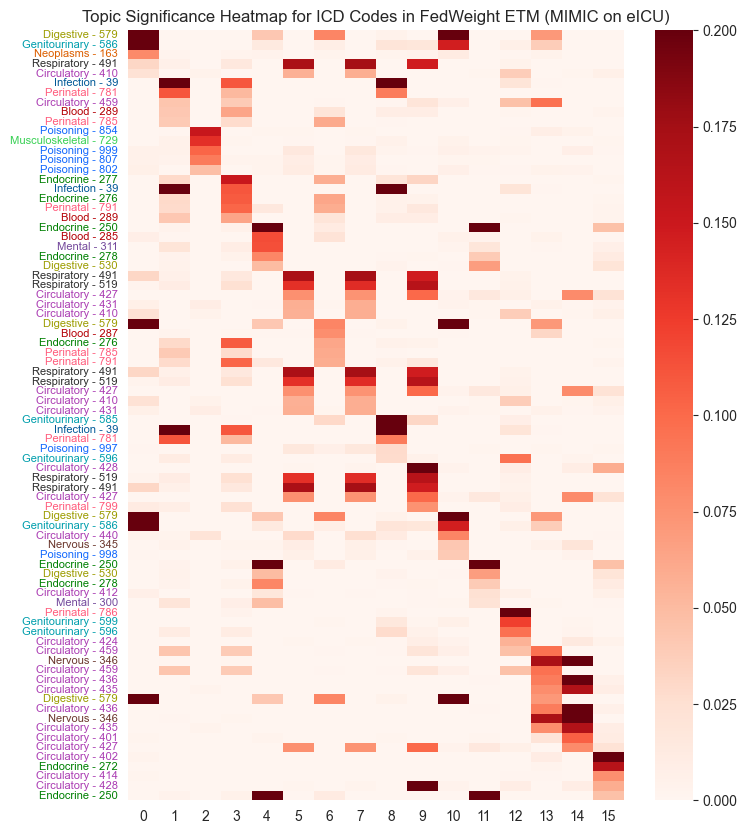

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

weighted_eicu_disease_topic_p_values_t = weighted_eicu_disease_topic_p_values.T # K x ICD
weighted_eicu_disease_topic_p_values_t = weighted_eicu_disease_topic_p_values_t / weighted_eicu_disease_topic_p_values_t.sum(axis=1, keepdims=True) # K x ICD
total_top_icd_idx = np.zeros((weighted_eicu_disease_topic_p_values_t.shape[0], 5))  # K x 3

for topic in range(weighted_eicu_disease_topic_p_values_t.shape[0]):
    topic_icds = weighted_eicu_disease_topic_p_values_t[topic, :]
    top_icd_idx = np.flip(np.argsort(topic_icds))[:5]  # Top 5 ICD codes
    total_top_icd_idx[topic] = top_icd_idx

total_top_icd_idx = np.ravel(total_top_icd_idx).astype(int)

eicu_total_top_icd = weighted_eicu_disease_topic_p_values_t[:, total_top_icd_idx]
eicu_total_top_icd = eicu_total_top_icd.T

total_top_icd_names = [significant_icd_codes[idx] for idx in total_top_icd_idx]
disease = [convert_icd9_to_disease(x) for x in total_top_icd_names]
disease_label = [f"{disease[i]} - {total_top_icd_names[i]}" for i in range(len(disease))]

plt.figure(figsize=(8, 10))

# Plot heatmap
plt.title("Topic Significance Heatmap for ICD Codes in FedWeight ETM (MIMIC on eICU)")
ax = sns.heatmap(eicu_total_top_icd,
            yticklabels=disease_label,
            cmap='Reds', vmax=0.2)

ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

y_labels = plt.gca().get_yticklabels()
for i, label in enumerate(y_labels):
    color = disease_color_map[disease[i]]
    label.set_color(color)
    
plt.show()

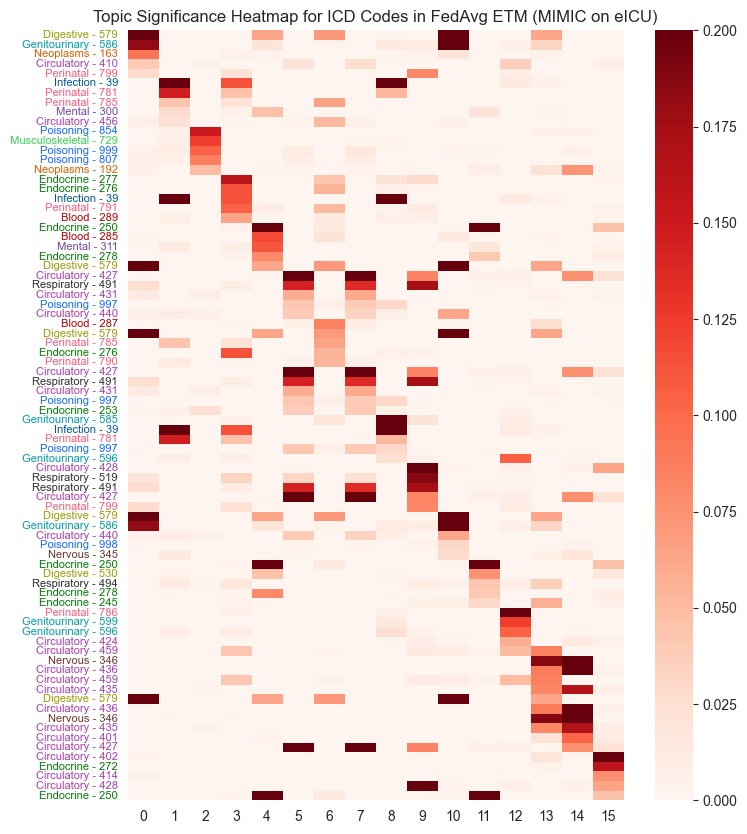

In [30]:
unweighted_eicu_disease_topic_p_values_t = unweighted_eicu_disease_topic_p_values.T # K x ICD
unweighted_eicu_disease_topic_p_values_t = unweighted_eicu_disease_topic_p_values_t / unweighted_eicu_disease_topic_p_values_t.sum(axis=1, keepdims=True) # K x ICD
total_top_icd_idx = np.zeros((unweighted_eicu_disease_topic_p_values_t.shape[0], 5))  # K x 3

for topic in range(unweighted_eicu_disease_topic_p_values_t.shape[0]):
    topic_icds = unweighted_eicu_disease_topic_p_values_t[topic, :]
    top_icd_idx = np.flip(np.argsort(topic_icds))[:5]  # Top 5 ICD codes
    total_top_icd_idx[topic] = top_icd_idx

total_top_icd_idx = np.ravel(total_top_icd_idx).astype(int)

eicu_total_top_icd = unweighted_eicu_disease_topic_p_values_t[:, total_top_icd_idx]
eicu_total_top_icd = eicu_total_top_icd.T

total_top_icd_names = [significant_icd_codes[idx] for idx in total_top_icd_idx]
disease = [convert_icd9_to_disease(x) for x in total_top_icd_names]
disease_label = [f"{disease[i]} - {total_top_icd_names[i]}" for i in range(len(disease))]

plt.figure(figsize=(8, 10))

# Plot heatmap
plt.title("Topic Significance Heatmap for ICD Codes in FedAvg ETM (MIMIC on eICU)")
ax = sns.heatmap(eicu_total_top_icd,
            yticklabels=disease_label,
            cmap='Reds', vmax=0.2)

ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

y_labels = plt.gca().get_yticklabels()
for i, label in enumerate(y_labels):
    color = disease_color_map[disease[i]]
    label.set_color(color)
    
plt.show()

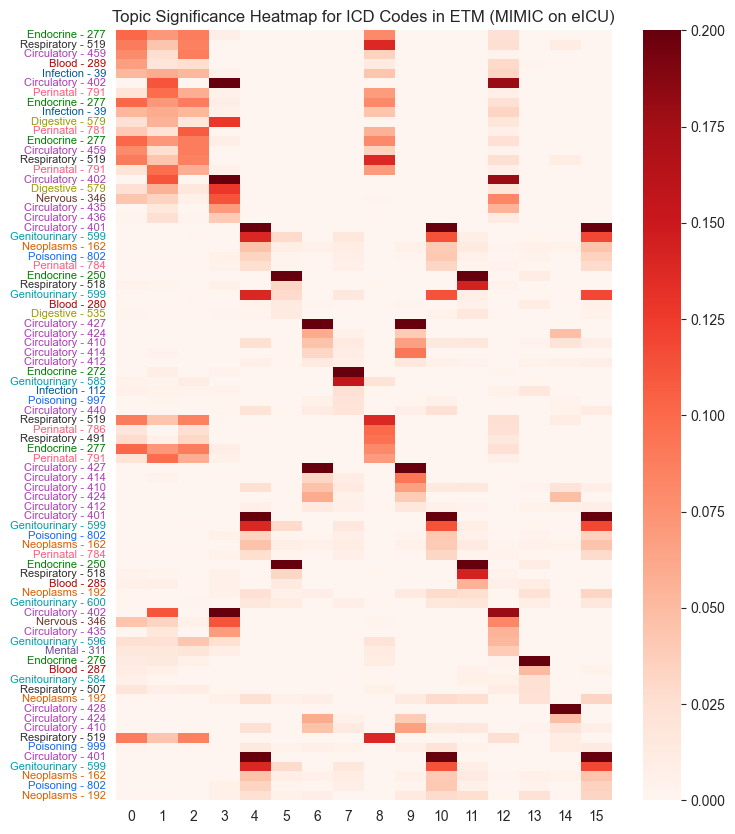

In [31]:
etm_eicu_disease_topic_p_values_t = etm_eicu_disease_topic_p_values.T # K x ICD
etm_eicu_disease_topic_p_values_t = etm_eicu_disease_topic_p_values_t / etm_eicu_disease_topic_p_values_t.sum(axis=1, keepdims=True) # K x ICD
total_top_icd_idx = np.zeros((etm_eicu_disease_topic_p_values_t.shape[0], 5))  # K x 3

for topic in range(etm_eicu_disease_topic_p_values_t.shape[0]):
    topic_icds = etm_eicu_disease_topic_p_values_t[topic, :]
    top_icd_idx = np.flip(np.argsort(topic_icds))[:5]  # Top 5 ICD codes
    total_top_icd_idx[topic] = top_icd_idx

total_top_icd_idx = np.ravel(total_top_icd_idx).astype(int)

eicu_total_top_icd = etm_eicu_disease_topic_p_values_t[:, total_top_icd_idx]
eicu_total_top_icd = eicu_total_top_icd.T

total_top_icd_names = [significant_icd_codes[idx] for idx in total_top_icd_idx]
disease = [convert_icd9_to_disease(x) for x in total_top_icd_names]
disease_label = [f"{disease[i]} - {total_top_icd_names[i]}" for i in range(len(disease))]

plt.figure(figsize=(8, 10))

# Plot heatmap
plt.title("Topic Significance Heatmap for ICD Codes in ETM (MIMIC on eICU)")
ax = sns.heatmap(eicu_total_top_icd,
            yticklabels=disease_label,
            cmap='Reds', vmax=0.2)

ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

y_labels = plt.gca().get_yticklabels()
for i, label in enumerate(y_labels):
    color = disease_color_map[disease[i]]
    label.set_color(color)
    
plt.show()

In [32]:
# from scipy.stats import ranksums
from scipy.stats import mannwhitneyu # Wilcoxon rank-sum test (one-sided Mann-Whitney U test)

weighted_mimic_disease_p_values = {}
weighted_mimic_disease_topic_p_values = np.zeros((len(significant_icd_codes), num_topics))

for disease_idx, disease in enumerate(significant_icd_codes):
    
    # ICD codes for disease category
    icd_code_idx = np.where(icd_code_names == disease)[0][0]
    readmit_weighted_mimic_test_icds = weighted_mimic_test_icds[weighted_mimic_test_readmit_row_ids]
    mimic_icd_input_disease = readmit_weighted_mimic_test_icds[:, icd_code_idx]
    
    # Find the patients if the disease is present
    patient_has_disease_indices = np.where(mimic_icd_input_disease == 1)[0]
    patient_no_disease_indices = np.where(mimic_icd_input_disease == 0)[0]
    
    if len(patient_has_disease_indices) == 0 or len(patient_no_disease_indices) == 0:
        continue
    
    smallest_p_value = np.inf
    for topic in range(num_topics):
        theta_topic = X_mimic_test_weighted[:, topic]
        theta_topic_has_disease = theta_topic[patient_has_disease_indices]
        theta_topic_no_disease = theta_topic[patient_no_disease_indices]
        _, p_value = mannwhitneyu(theta_topic_has_disease, theta_topic_no_disease, alternative="greater")
        weighted_mimic_disease_topic_p_values[disease_idx][topic] = -np.log10(p_value)
        if p_value < smallest_p_value:
            smallest_p_value = p_value
    
    weighted_mimic_disease_p_values[disease] = -np.log10(smallest_p_value)
    
# eICU on MIMIC
weighted_mimic_disease_p_values

{'8': 10.981450471988257,
 '39': 1.3477604962300045,
 '41': 12.125020596450993,
 '42': 4.841964383690823,
 '70': 24.077854660054108,
 '112': 8.853247557289222,
 '155': 8.97933590332607,
 '162': 6.959583452702144,
 '191': 3.34307670930579,
 '197': 12.09835456176359,
 '198': 13.37535383930391,
 '202': 6.455168553676091,
 '238': 3.20220261842177,
 '245': 2.1374301510752747,
 '250': 98.03224639038133,
 '253': 5.234804086495531,
 '263': 12.365416217703704,
 '272': 132.33172395784985,
 '276': 79.15497204229,
 '277': 3.1860181678433506,
 '278': 21.41619354272499,
 '280': 11.712131002807572,
 '285': 71.50840810415731,
 '286': 13.852533802638632,
 '287': 46.8084462772928,
 '289': 8.496246883198616,
 '293': 6.167802190488735,
 '294': 5.7898806654749695,
 '296': 10.635819625138533,
 '300': 9.602525999699884,
 '311': 22.451012652185238,
 '331': 5.247539166059214,
 '333': 3.447844528743457,
 '345': 11.182849745631415,
 '346': 3.7323489313946463,
 '357': 7.50753785163905,
 '397': 3.319080274680517,


In [33]:
# from scipy.stats import ranksums
from scipy.stats import mannwhitneyu # Wilcoxon rank-sum test (one-sided Mann-Whitney U test)

unweighted_mimic_disease_p_values = {}
unweighted_mimic_disease_topic_p_values = np.zeros((len(significant_icd_codes), num_topics))

for disease_idx, disease in enumerate(significant_icd_codes):
    
    # ICD codes for disease category
    icd_code_idx = np.where(icd_code_names == disease)[0][0]
    readmit_unweighted_mimic_test_icds = unweighted_mimic_test_icds[unweighted_mimic_test_readmit_row_ids]
    mimic_icd_input_disease = readmit_unweighted_mimic_test_icds[:, icd_code_idx]
    
    # Find the patients if the disease is present
    patient_has_disease_indices = np.where(mimic_icd_input_disease == 1)[0]
    patient_no_disease_indices = np.where(mimic_icd_input_disease == 0)[0]
    
    if len(patient_has_disease_indices) == 0 or len(patient_no_disease_indices) == 0:
        continue
    
    smallest_p_value = np.inf
    for topic in range(num_topics):
        theta_topic = X_mimic_test_unweighted[:, topic]
        theta_topic_has_disease = theta_topic[patient_has_disease_indices]
        theta_topic_no_disease = theta_topic[patient_no_disease_indices]
        _, p_value = mannwhitneyu(theta_topic_has_disease, theta_topic_no_disease, alternative="greater")
        unweighted_mimic_disease_topic_p_values[disease_idx][topic] = -np.log10(p_value)
        if p_value < smallest_p_value:
            smallest_p_value = p_value
    
    unweighted_mimic_disease_p_values[disease] = -np.log10(smallest_p_value)
    
# eICU on MIMIC
unweighted_mimic_disease_p_values

{'8': 10.296776125481184,
 '39': 1.360827232181071,
 '41': 11.78224700647585,
 '42': 5.1163714200715065,
 '70': 20.83257720153222,
 '112': 7.440077169596506,
 '155': 8.123076589131234,
 '162': 7.349520330907847,
 '191': 3.5529681552736645,
 '197': 13.790327466905927,
 '198': 17.393210000602345,
 '202': 6.4153542942246204,
 '238': 3.7064505919379687,
 '245': 2.129361053218629,
 '250': 99.48783799932771,
 '253': 5.744845053882431,
 '263': 9.495063795316575,
 '272': 132.3362740288439,
 '276': 109.59559909415232,
 '277': 3.5065575792406682,
 '278': 21.201191250087817,
 '280': 10.430768315812818,
 '285': 69.00046785547177,
 '286': 16.258976657605572,
 '287': 43.047377965589725,
 '289': 8.302666157957608,
 '293': 6.454894588594474,
 '294': 4.8491133239093696,
 '296': 10.342323310058209,
 '300': 10.744282432237553,
 '311': 23.55071077138335,
 '331': 4.615843570157539,
 '333': 3.1017667091111107,
 '345': 11.359646294807202,
 '346': 3.6568483890721644,
 '357': 7.6088128227213305,
 '397': 3.0952

In [34]:
# from scipy.stats import ranksums
from scipy.stats import mannwhitneyu # Wilcoxon rank-sum test (one-sided Mann-Whitney U test)

etm_mimic_disease_p_values = {}
etm_mimic_disease_topic_p_values = np.zeros((len(significant_icd_codes), num_topics))

for disease_idx, disease in enumerate(significant_icd_codes):
    
    # ICD codes for disease category
    icd_code_idx = np.where(icd_code_names == disease)[0][0]
    readmit_etm_mimic_test_icds = etm_mimic_test_icds[etm_mimic_test_readmit_row_ids]
    mimic_icd_input_disease = readmit_etm_mimic_test_icds[:, icd_code_idx]
    
    # Find the patients if the disease is present
    patient_has_disease_indices = np.where(mimic_icd_input_disease == 1)[0]
    patient_no_disease_indices = np.where(mimic_icd_input_disease == 0)[0]
    
    if len(patient_has_disease_indices) == 0 or len(patient_no_disease_indices) == 0:
        continue
    
    smallest_p_value = np.inf
    for topic in range(num_topics):
        theta_topic = X_mimic_test_etm[:, topic]
        theta_topic_has_disease = theta_topic[patient_has_disease_indices]
        theta_topic_no_disease = theta_topic[patient_no_disease_indices]
        _, p_value = mannwhitneyu(theta_topic_has_disease, theta_topic_no_disease, alternative="greater")
        etm_mimic_disease_topic_p_values[disease_idx][topic] = -np.log10(p_value)
        if p_value < smallest_p_value:
            smallest_p_value = p_value
    
    etm_mimic_disease_p_values[disease] = -np.log10(smallest_p_value)
    
# eICU on MIMIC
etm_mimic_disease_p_values

{'8': 10.77967663001515,
 '39': 1.2983765307665167,
 '41': 11.023779791421207,
 '42': 2.580507016388927,
 '70': 12.811817263756197,
 '112': 9.33777203887846,
 '155': 9.484248838298626,
 '162': 4.871745364117402,
 '191': 3.434630389444511,
 '197': 13.234980661543238,
 '198': 19.491781200768724,
 '202': 2.1973034836255643,
 '238': 1.1808714222372465,
 '245': 1.9697784071257383,
 '250': 203.42894958157908,
 '253': 6.47580926368237,
 '263': 12.082951194505505,
 '272': 133.52052918969648,
 '276': 11.463268929251887,
 '277': 2.8073696734354625,
 '278': 10.354951383219401,
 '280': 5.392576119889106,
 '285': 39.10490138049494,
 '286': 19.618816244154125,
 '287': 59.575179824068776,
 '289': 3.72173805446585,
 '293': 6.342497266163034,
 '294': 5.416248024924221,
 '296': 8.764362001524976,
 '300': 10.643364980209386,
 '311': 3.339241477979156,
 '331': 3.295474572821985,
 '333': 2.447938818476732,
 '345': 22.741685993258436,
 '346': 6.928588125954119,
 '357': 11.036271775617674,
 '397': 2.67333039

<Figure size 640x480 with 0 Axes>

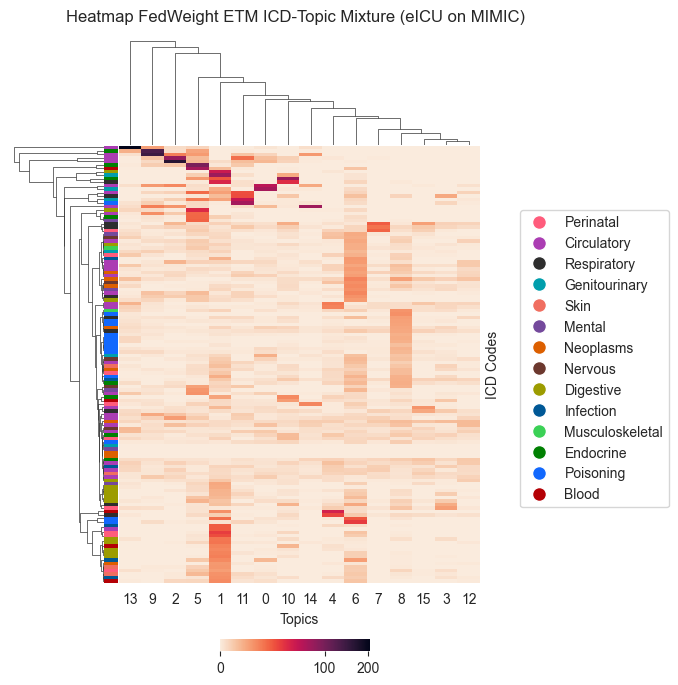

In [35]:
from scipy.cluster.hierarchy import linkage
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import seaborn as sns

# Create a seaborn clustermap
plt.clf()
row_clusters = linkage(weighted_mimic_disease_topic_p_values, method='ward')
col_clusters = linkage(weighted_mimic_disease_topic_p_values.T, method='ward')
disease_row_colors = pd.Series(significant_disease).map(disease_color_map).to_numpy()
g = sns.clustermap(weighted_mimic_disease_topic_p_values, row_linkage=row_clusters, col_linkage=col_clusters, 
                   figsize=(5, 6),
                   yticklabels=False, cmap='rocket_r',
                   cbar_kws={'orientation': 'horizontal', 'pad': 0.1, 'shrink': 0.6},
                   norm=PowerNorm(gamma=0.5),
                   cbar_pos=(0.45, -0.05, 0.3, 0.02),
                   row_colors=disease_row_colors)

g.fig.suptitle(f'Heatmap FedWeight ETM ICD-Topic Mixture (eICU on MIMIC)',
               fontsize=12, x=0.6, y=1.02)
g.ax_heatmap.set_xlabel('Topics')
g.ax_heatmap.set_ylabel('ICD Codes')

unique_diseases = list(set(significant_disease))
disease_legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=disease_color_map[disease],
                             markersize=10, label=disease) for disease in unique_diseases]

plt.legend(handles=disease_legend_patches, bbox_to_anchor=(2.0, 12), loc='lower left', borderaxespad=0.)

plt.show()
plt.close()

<Figure size 640x480 with 0 Axes>

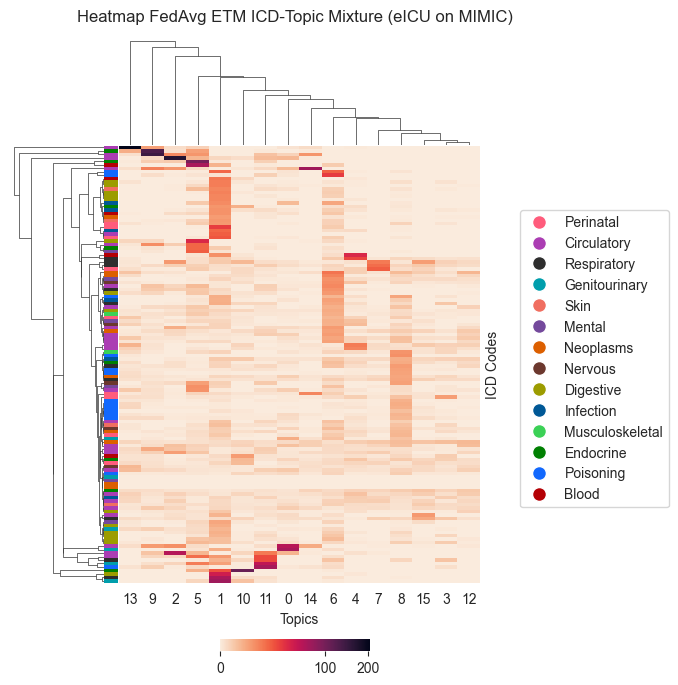

In [36]:
from scipy.cluster.hierarchy import linkage
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import seaborn as sns

# Create a seaborn clustermap
plt.clf()
row_clusters = linkage(unweighted_mimic_disease_topic_p_values, method='ward')
col_clusters = linkage(unweighted_mimic_disease_topic_p_values.T, method='ward')
disease_row_colors = pd.Series(significant_disease).map(disease_color_map).to_numpy()
g = sns.clustermap(unweighted_mimic_disease_topic_p_values, row_linkage=row_clusters, col_linkage=col_clusters, 
                   figsize=(5, 6),
                   yticklabels=False, cmap='rocket_r',
                   cbar_kws={'orientation': 'horizontal', 'pad': 0.1, 'shrink': 0.6},
                   norm=PowerNorm(gamma=0.5),
                   cbar_pos=(0.45, -0.05, 0.3, 0.02),
                   row_colors=disease_row_colors)

g.fig.suptitle(f'Heatmap FedAvg ETM ICD-Topic Mixture (eICU on MIMIC)',
               fontsize=12, x=0.6, y=1.02)
g.ax_heatmap.set_xlabel('Topics')
g.ax_heatmap.set_ylabel('ICD Codes')

unique_diseases = list(set(significant_disease))
disease_legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=disease_color_map[disease],
                             markersize=10, label=disease) for disease in unique_diseases]

plt.legend(handles=disease_legend_patches, bbox_to_anchor=(2.0, 12), loc='lower left', borderaxespad=0.)

plt.show()
plt.close()

<Figure size 640x480 with 0 Axes>

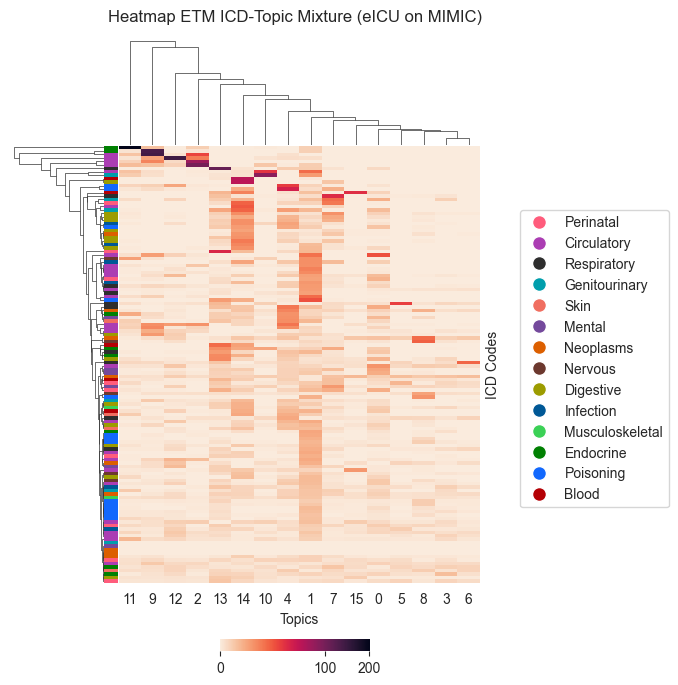

In [37]:
from scipy.cluster.hierarchy import linkage
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import seaborn as sns

# Create a seaborn clustermap
plt.clf()
row_clusters = linkage(etm_mimic_disease_topic_p_values, method='ward')
col_clusters = linkage(etm_mimic_disease_topic_p_values.T, method='ward')
disease_row_colors = pd.Series(significant_disease).map(disease_color_map).to_numpy()
g = sns.clustermap(etm_mimic_disease_topic_p_values, row_linkage=row_clusters, col_linkage=col_clusters, 
                   figsize=(5, 6),
                   yticklabels=False, cmap='rocket_r',
                   cbar_kws={'orientation': 'horizontal', 'pad': 0.1, 'shrink': 0.6},
                   norm=PowerNorm(gamma=0.5),
                   cbar_pos=(0.45, -0.05, 0.3, 0.02),
                   row_colors=disease_row_colors)

g.fig.suptitle(f'Heatmap ETM ICD-Topic Mixture (eICU on MIMIC)',
               fontsize=12, x=0.6, y=1.02)
g.ax_heatmap.set_xlabel('Topics')
g.ax_heatmap.set_ylabel('ICD Codes')

unique_diseases = list(set(significant_disease))
disease_legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=disease_color_map[disease],
                             markersize=10, label=disease) for disease in unique_diseases]

plt.legend(handles=disease_legend_patches, bbox_to_anchor=(2.0, 12), loc='lower left', borderaxespad=0.)

plt.show()
plt.close()

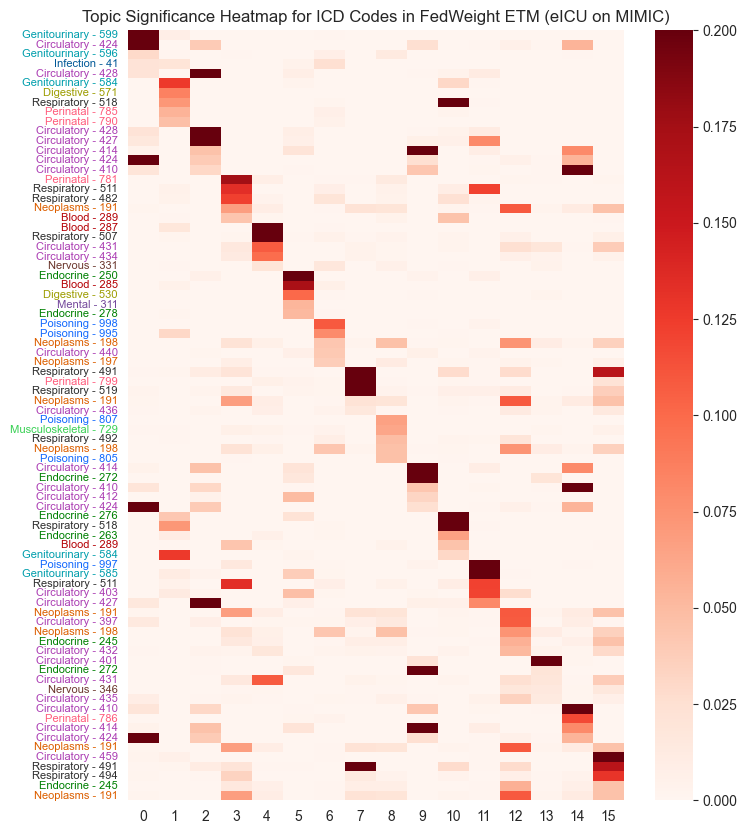

In [38]:
weighted_mimic_disease_topic_p_values_t = weighted_mimic_disease_topic_p_values.T # K x ICD
weighted_mimic_disease_topic_p_values_t = weighted_mimic_disease_topic_p_values_t / weighted_mimic_disease_topic_p_values_t.sum(axis=1, keepdims=True) # K x ICD
total_top_icd_idx = np.zeros((weighted_mimic_disease_topic_p_values_t.shape[0], 5))  # K x 3

for topic in range(weighted_mimic_disease_topic_p_values_t.shape[0]):
    topic_icds = weighted_mimic_disease_topic_p_values_t[topic, :]
    top_icd_idx = np.flip(np.argsort(topic_icds))[:5]  # Top 5 ICD codes
    total_top_icd_idx[topic] = top_icd_idx

total_top_icd_idx = np.ravel(total_top_icd_idx).astype(int)

mimic_total_top_icd = weighted_mimic_disease_topic_p_values_t[:, total_top_icd_idx]
mimic_total_top_icd = mimic_total_top_icd.T

total_top_icd_names = [significant_icd_codes[idx] for idx in total_top_icd_idx]
disease = [convert_icd9_to_disease(x) for x in total_top_icd_names]
disease_label = [f"{disease[i]} - {total_top_icd_names[i]}" for i in range(len(disease))]

plt.figure(figsize=(8, 10))

# Plot heatmap
plt.title("Topic Significance Heatmap for ICD Codes in FedWeight ETM (eICU on MIMIC)")
ax = sns.heatmap(mimic_total_top_icd,
            yticklabels=disease_label,
            cmap='Reds', vmax=0.2)

ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

y_labels = plt.gca().get_yticklabels()
for i, label in enumerate(y_labels):
    color = disease_color_map[disease[i]]
    label.set_color(color)
    
plt.show()

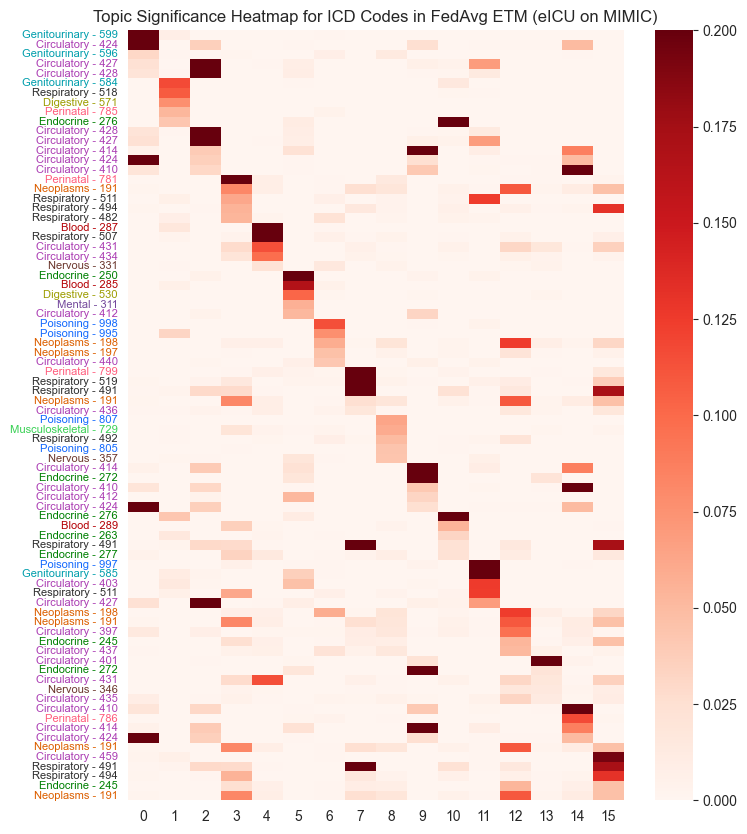

In [39]:
unweighted_mimic_disease_topic_p_values_t = unweighted_mimic_disease_topic_p_values.T # K x ICD
unweighted_mimic_disease_topic_p_values_t = unweighted_mimic_disease_topic_p_values_t / unweighted_mimic_disease_topic_p_values_t.sum(axis=1, keepdims=True) # K x ICD
total_top_icd_idx = np.zeros((unweighted_mimic_disease_topic_p_values_t.shape[0], 5))  # K x 3

for topic in range(unweighted_mimic_disease_topic_p_values_t.shape[0]):
    topic_icds = unweighted_mimic_disease_topic_p_values_t[topic, :]
    top_icd_idx = np.flip(np.argsort(topic_icds))[:5]  # Top 5 ICD codes
    total_top_icd_idx[topic] = top_icd_idx

total_top_icd_idx = np.ravel(total_top_icd_idx).astype(int)

mimic_total_top_icd = unweighted_mimic_disease_topic_p_values_t[:, total_top_icd_idx]
mimic_total_top_icd = mimic_total_top_icd.T

total_top_icd_names = [significant_icd_codes[idx] for idx in total_top_icd_idx]
disease = [convert_icd9_to_disease(x) for x in total_top_icd_names]
disease_label = [f"{disease[i]} - {total_top_icd_names[i]}" for i in range(len(disease))]

plt.figure(figsize=(8, 10))

# Plot heatmap
plt.title("Topic Significance Heatmap for ICD Codes in FedAvg ETM (eICU on MIMIC)")
ax = sns.heatmap(mimic_total_top_icd,
            yticklabels=disease_label,
            cmap='Reds', vmax=0.2)

ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

y_labels = plt.gca().get_yticklabels()
for i, label in enumerate(y_labels):
    color = disease_color_map[disease[i]]
    label.set_color(color)
    
plt.show()

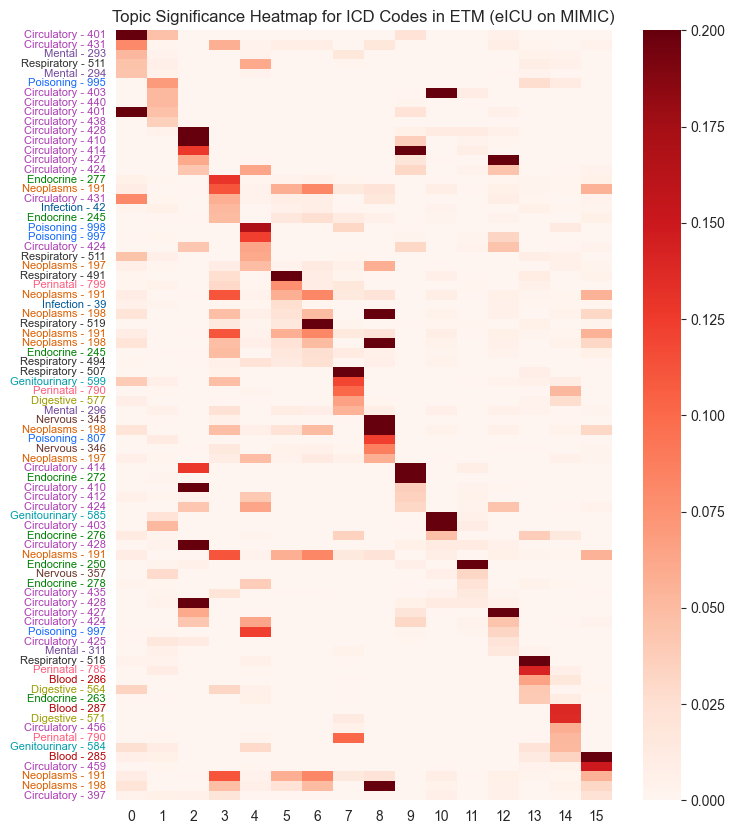

In [40]:
etm_mimic_disease_topic_p_values_t = etm_mimic_disease_topic_p_values.T # K x ICD
etm_mimic_disease_topic_p_values_t = etm_mimic_disease_topic_p_values_t / etm_mimic_disease_topic_p_values_t.sum(axis=1, keepdims=True) # K x ICD
total_top_icd_idx = np.zeros((etm_mimic_disease_topic_p_values_t.shape[0], 5))  # K x 3

for topic in range(etm_mimic_disease_topic_p_values_t.shape[0]):
    topic_icds = etm_mimic_disease_topic_p_values_t[topic, :]
    top_icd_idx = np.flip(np.argsort(topic_icds))[:5]  # Top 5 ICD codes
    total_top_icd_idx[topic] = top_icd_idx

total_top_icd_idx = np.ravel(total_top_icd_idx).astype(int)

mimic_total_top_icd = etm_mimic_disease_topic_p_values_t[:, total_top_icd_idx]
mimic_total_top_icd = mimic_total_top_icd.T

total_top_icd_names = [significant_icd_codes[idx] for idx in total_top_icd_idx]
disease = [convert_icd9_to_disease(x) for x in total_top_icd_names]
disease_label = [f"{disease[i]} - {total_top_icd_names[i]}" for i in range(len(disease))]

plt.figure(figsize=(8, 10))

# Plot heatmap
plt.title("Topic Significance Heatmap for ICD Codes in ETM (eICU on MIMIC)")
ax = sns.heatmap(mimic_total_top_icd,
            yticklabels=disease_label,
            cmap='Reds', vmax=0.2)

ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

y_labels = plt.gca().get_yticklabels()
for i, label in enumerate(y_labels):
    color = disease_color_map[disease[i]]
    label.set_color(color)
    
plt.show()

In [41]:
significant_icd_code_index = []
for icd_code in significant_icd_codes:
    idx = np.where(icd_code_names == icd_code)[0][0]
    significant_icd_code_index.append(idx)
significant_icd_code_index = np.array(significant_icd_code_index)

In [42]:
eicu_significant_test_readmit_icds = etm_eicu_test_icds[etm_eicu_test_readmit_row_ids]
eicu_significant_test_readmit_icds = eicu_significant_test_readmit_icds[:, significant_icd_code_index]
eicu_bow_test = []
for row in eicu_significant_test_readmit_icds:
    word_id = list(np.where(row == 1)[0])
    eicu_bow_test.append(word_id)
eicu_bow_test

[[11, 12, 92],
 [70],
 [],
 [36, 52],
 [41, 107],
 [],
 [16],
 [106],
 [16, 21, 22, 25, 41, 65, 75, 93],
 [15, 21, 37, 41, 51],
 [21, 52, 65, 75, 92, 93, 107],
 [22, 40, 41, 51, 75, 98, 111],
 [10, 41, 51],
 [1, 20, 21, 22, 65, 92, 95, 103, 107, 110],
 [],
 [1, 31, 33, 37, 41, 52, 57, 68, 70, 74, 75, 92, 100, 107, 110, 111],
 [15, 20, 21, 65, 80, 92, 106],
 [20, 27, 32, 75, 107, 111],
 [56],
 [41],
 [15, 36],
 [39, 51],
 [],
 [],
 [20, 68, 75, 103, 107],
 [],
 [15, 33, 41, 51, 56],
 [21, 41, 46, 52, 68, 75],
 [],
 [107],
 [21, 37, 92],
 [49, 52, 92],
 [21, 41, 65, 110],
 [90],
 [51, 65, 70, 93],
 [20, 49, 51, 52, 65, 92, 107, 110],
 [15, 21, 22, 24, 41, 52, 75, 92, 93, 103, 110, 111],
 [74, 75],
 [103],
 [26, 31, 70, 75, 106, 110],
 [21, 32, 37, 99, 100, 107],
 [52],
 [19, 41, 46, 107],
 [20, 21, 27, 51, 52, 75, 92],
 [],
 [],
 [1, 61, 75, 90, 93, 107, 111],
 [1, 52, 68, 75, 94, 107],
 [],
 [6, 21, 86],
 [41],
 [16],
 [1, 21, 65],
 [1, 20, 65, 92],
 [1, 27, 29, 110],
 [1, 68],
 [64],
 

In [43]:
mimic_significant_test_readmit_icds = etm_mimic_test_icds[etm_mimic_test_readmit_row_ids]
mimic_significant_test_readmit_icds = mimic_significant_test_readmit_icds[:, significant_icd_code_index]
mimic_bow_test = []
for row in mimic_significant_test_readmit_icds:
    word_id = list(np.where(row == 1)[0])
    mimic_bow_test.append(word_id)
mimic_bow_test

[[5, 20, 24, 26, 40, 43, 46, 47, 49, 74, 86, 91, 95, 106, 122],
 [16, 20, 40, 52, 74, 91, 106, 122],
 [],
 [2, 4, 16, 20, 24, 26, 40, 74, 83, 87, 95, 122, 124],
 [40, 66, 108],
 [19, 40, 46, 124],
 [2, 5, 19, 20, 47, 67, 74, 86, 91, 92, 95, 107],
 [20, 62, 66, 74],
 [25, 40, 52, 54, 74, 109],
 [5, 16, 43, 51, 73, 77, 89, 95],
 [24, 26, 91],
 [19, 40, 46, 49, 52, 76, 96],
 [17, 18, 24, 40, 49, 52, 67, 74],
 [25, 40, 48, 49, 51, 61, 124],
 [16, 20, 23, 50, 51],
 [44, 46, 52],
 [24, 50, 51, 52, 74, 75, 76, 106],
 [24, 25, 40, 65, 89, 105, 108],
 [16, 42, 46, 52, 71, 92, 116],
 [76, 79, 86, 91, 95],
 [5, 20, 76, 78, 89, 95],
 [11, 12, 20, 23, 40, 73, 88, 91],
 [16, 124],
 [20, 55, 68, 89, 95, 109],
 [43, 46, 51, 123],
 [40, 73, 95],
 [20, 40, 64, 79, 81, 86, 91],
 [19, 24, 40, 43, 46, 51],
 [2, 9, 20, 24, 31, 74, 95, 97, 122],
 [16, 19, 43, 44, 46, 52, 60],
 [46, 51, 73, 92, 106],
 [19, 40, 46, 61, 76, 96, 124],
 [19, 22, 30, 31, 76, 102],
 [16,
  22,
  25,
  42,
  51,
  52,
  65,
  68,
  

In [44]:
eicu_coherence = get_topic_coherence(weighted_eicu_disease_topic_p_values_t, eicu_bow_test, 3)
eicu_diversity = get_topic_diversity(weighted_eicu_disease_topic_p_values_t, 3)
eicu_quality = eicu_coherence * eicu_diversity
print("eICU ETM FedWeight Topic Coherence: ", eicu_coherence)
print("eICU ETM FedWeight Topic Diversity: ", eicu_diversity)
print("eICU ETM FedWeight Topic Quality: ", eicu_quality)

eICU ETM FedWeight Topic Coherence:  0.5006456975322254
eICU ETM FedWeight Topic Diversity:  0.6666666666666666
eICU ETM FedWeight Topic Quality:  0.33376379835481695


In [45]:
eicu_coherence = get_topic_coherence(unweighted_eicu_disease_topic_p_values_t, eicu_bow_test, 3)
eicu_diversity = get_topic_diversity(unweighted_eicu_disease_topic_p_values_t, 3)
eicu_quality = eicu_coherence * eicu_diversity
print("eICU ETM FedAvg Topic Coherence: ", eicu_coherence)
print("eICU ETM FedAvg Topic Diversity: ", eicu_diversity)
print("eICU ETM FedAvg Topic Quality: ", eicu_quality)

eICU ETM FedAvg Topic Coherence:  0.4976716850255757
eICU ETM FedAvg Topic Diversity:  0.7083333333333334
eICU ETM FedAvg Topic Quality:  0.3525174435597828


In [46]:
eicu_coherence = get_topic_coherence(etm_eicu_disease_topic_p_values_t, eicu_bow_test, 3)
eicu_diversity = get_topic_diversity(etm_eicu_disease_topic_p_values_t, 3)
eicu_quality = eicu_coherence * eicu_diversity
print("eICU ETM Topic Coherence: ", eicu_coherence)
print("eICU ETM Topic Diversity: ", eicu_diversity)
print("eICU ETM Topic Quality: ", eicu_quality)

eICU ETM Topic Coherence:  0.49715373435504157
eICU ETM Topic Diversity:  0.6041666666666666
eICU ETM Topic Quality:  0.30036371450617094


In [47]:
mimic_coherence = get_topic_coherence(weighted_mimic_disease_topic_p_values_t, mimic_bow_test, 3)
mimic_diversity = get_topic_diversity(weighted_mimic_disease_topic_p_values_t, 3)
mimic_quality = mimic_coherence * mimic_diversity
print("MIMIC ETM FedWeight Topic Coherence: ", mimic_coherence)
print("MIMIC ETM FedWeight Topic Diversity: ", mimic_diversity)
print("MIMIC ETM FedWeight Topic Quality: ", mimic_quality)

MIMIC ETM FedWeight Topic Coherence:  0.4968647961738462
MIMIC ETM FedWeight Topic Diversity:  0.8125
MIMIC ETM FedWeight Topic Quality:  0.40370264689125007


In [48]:
mimic_coherence = get_topic_coherence(unweighted_mimic_disease_topic_p_values_t, mimic_bow_test, 3)
mimic_diversity = get_topic_diversity(unweighted_mimic_disease_topic_p_values_t, 3)
mimic_quality = mimic_coherence * mimic_diversity
print("MIMIC ETM FedAvg Topic Coherence: ", mimic_coherence)
print("MIMIC ETM FedAvg Topic Diversity: ", mimic_diversity)
print("MIMIC ETM FedAvg Topic Quality: ", mimic_quality)

MIMIC ETM FedAvg Topic Coherence:  0.4956993920994229
MIMIC ETM FedAvg Topic Diversity:  0.8333333333333334
MIMIC ETM FedAvg Topic Quality:  0.41308282674951907


In [49]:
mimic_coherence = get_topic_coherence(etm_mimic_disease_topic_p_values_t, mimic_bow_test, 3)
mimic_diversity = get_topic_diversity(etm_mimic_disease_topic_p_values_t, 3)
mimic_quality = mimic_coherence * mimic_diversity
print("MIMIC ETM Topic Coherence: ", mimic_coherence)
print("MIMIC ETM Topic Diversity: ", mimic_diversity)
print("MIMIC ETM Topic Quality: ", mimic_quality)

MIMIC ETM Topic Coherence:  0.4979115141585589
MIMIC ETM Topic Diversity:  0.7916666666666666
MIMIC ETM Topic Quality:  0.3941799487088591
